In [ ]:
#pip install wheel

In [11]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 199 kB 26.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import gc
import sys
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [2]:
random.seed(246810)
np.random.seed(246810)

# Import data:

In [ ]:
CURR_DIR = ""

datasets = {}

# for data_name in ["train_identity", "train_transaction", "test_identity", "test_transaction"]:
    
for data_name in ["train_identity", "train_transaction"]:
    data = pd.read_csv(CURR_DIR + data_name + ".csv")
    datasets[data_name] = data

datasets.keys()

In [ ]:
transaction_train = datasets['train_transaction']
identity_train = datasets['train_identity']

# transaction_test = datasets['test_transaction']
# identity_test = datasets['test_identity']

In [ ]:
#transaction_train.shape

Columns in test set have wrong labels:

In [ ]:
#identity_test.columns = identity_test.columns.str.replace('^id-', 'id_', regex = True)

Merge data

In [ ]:
complete_train = transaction_train.merge(identity_train,on=['TransactionID'],how='left', indicator=True)
complete_train = complete_train[complete_train['_merge'] == "both"]
complete_train.drop(['_merge'], axis=1,inplace = True)
complete_train.shape

# merged_test = transaction_test.merge(identity_test,on=['TransactionID'],how='left', indicator=True)
# complete_test = merged_test[merged_test['_merge'] == "both"]
# complete_test.shape

There are some columns that besides being categorical, have a different type. Therefore, we explicitly assign their type

In [ ]:
categorical_cols = ['TransactionID','ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

numeric_cols = list(set(complete_train.columns) - set(categorical_cols)) 

for col in categorical_cols:
    if col in complete_train.columns:
        complete_train[col] = complete_train[col].astype('object')
#         complete_test[col] = complete_test[col].astype('object')


# Missing values per column

In [ ]:
# For different thresholds, this function gives us variables with that % of missings
def missing_info(dataset, max_percent_missings = 90):
    nrows = dataset.shape[0]
    ncols = dataset.shape[1]
    missings = np.transpose((1 - dataset.describe(include='all').loc[['count']] / nrows) * 100)
    missings = missings.rename(columns = {'count':'missing_percent'})
    missings.sort_values(by = ['missing_percent'], ascending = False, inplace = True)
    
    filter_missings  = missings['missing_percent'] > max_percent_missings
    
    print(f"Your complete data set has {nrows} observations and {ncols} variables")
    print(f"From those, {missings[filter_missings].shape[0]} have more than {max_percent_missings} % of missing values")
    
    print(f"Such variables are: \n {missings[filter_missings]}")
    return(missings[filter_missings],missings[~filter_missings])

In [ ]:
cols_to_remove, cols_not_remove = missing_info(complete_train, 70)
cols_not_remove = cols_not_remove.index.values.tolist()

In [ ]:
complete_train = complete_train[cols_not_remove]

#cols_not_remove.remove('isFraud')
# complete_test = complete_test[cols_not_remove]

In [ ]:
#complete_test.head()

### Export data without missing imputation

In [ ]:
# create a ZipFile object
#zipObj = ZipFile('no_clean_database.zip', 'w')
# Add multiple files to the zip
###X_train.to_csv("X_train.csv", index = False)
###X_test.to_csv("X_test.csv", index = False)
###y_train.to_csv("y_train.csv", index = False)
# close the Zip File
#zipObj.close()

## Missing imputation

In [ ]:
# Update list of numerical and categorical variables:
numeric_cols = list(set(cols_not_remove) & set(numeric_cols))
categorical_cols = list(set(cols_not_remove) & set(categorical_cols))


In [ ]:
# import os, psutil
# process = psutil.Process(os.getpid())
# print(process.memory_info().rss)

In [ ]:
# Fill the numeric variables with mean
for column in numeric_cols :
    mean = complete_train[column].mean()
#     complete_test[column].fillna(mean, inplace = True)
    complete_train[column].fillna(mean, inplace = True)
    
# Treatment for categoricals
for column in categorical_cols :
    mode = complete_train[column].mode()[0]
 #   complete_test[column].fillna(mode, inplace = True)
    complete_train[column].fillna(mode, inplace = True)

In [ ]:
y_train = complete_train['isFraud']

X_train = complete_train.drop(['TransactionID', 'isFraud'], axis=1)

### Export data with missing imputation

In [ ]:
# create a ZipFile object
#zipObj = ZipFile('clean_database.zip', 'w')
# Add multiple files to the zip
####X_train.to_csv("X_train.csv", index = False)
###X_test.to_csv("X_test.csv", index = False)
###y_train.to_csv("y_train.csv", index = False)
# close the Zip File
#zipObj.close()

# Import cleaned data:


In [ ]:
# CURR_DIR = "./clean_database/"

# datasets =  {}

# for data_name in ["X_train", "X_test", "y_train"]:
#     data = pd.read_csv(CURR_DIR + data_name + ".csv")
#     datasets[data_name] = data

# datasets.keys()

In [ ]:
# X_train = datasets['X_train']
# X_test = datasets['X_test']
# y_train = datasets['y_train']

In [ ]:
# X_train.columns

In [ ]:
# X_train['TransactionDT']

# Feature engineering

In [ ]:
# P_emaildomain
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

email_suffix = ['com', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    X_train[c + '_bin'] = X_train[c].map(emails)
    #X_test[c + '_bin'] = X_test[c].map(emails)
    
    X_train[c + '_suffix'] = X_train[c].map(lambda x: str(x).split('.')[-1])
    #X_test[c + '_suffix'] = X_test[c].map(lambda x: str(x).split('.')[-1])
    
    X_train[c + '_suffix'] = X_train[c + '_suffix'].map(lambda x: 'other' if str(x) not in email_suffix else x)
    #X_test[c + '_suffix'] = X_test[c + '_suffix'].map(lambda x: 'other' if str(x) not in email_suffix else x)

In [ ]:
X_train = X_train.drop(['P_emaildomain', 'R_emaildomain'],axis=1)
#X_test = X_test.drop(['P_emaildomain'],axis=1)

In [ ]:
#Card1,2,3,4, they are categorical data but with too many categories. 
#Since we don't know the meaning of them, we can't group them.
#num of categories: card1:13244, card2:497, card3:115, card5:102
for num in ['card1','card2','card3','card4','card5','card6', 'DeviceType', 'DeviceInfo']:
    print(num +' '+ str(len(X_train[num].unique())))
    
#for num in ['card1','card2','card3','card4','card5','card6']:
#    print(num +' '+ str(len(X_test[num].unique())))

In [ ]:
cols = ['card1','card2','card3','card5', 'DeviceInfo', 'addr1','addr2', 
        'id_18', 'id_33', 'id_30', 'id_14', 'id_13', 'id_20', 'id_19', 'id_17', 'id_31']

for col in cols:
    X_train['TransactionAmt_to_mean_' + col] = X_train['TransactionAmt'] / X_train.groupby([col])['TransactionAmt'].transform('mean')
    
X_train.drop(cols, axis=1, inplace = True)

In [ ]:
#So we group the transactions by each of the columns, 
#calculate the group average of transaction amount and drop the oringinal columns
# X_train['TransactionAmt_to_mean_card1'] = X_train['TransactionAmt'] / X_train.groupby(['card1'])['TransactionAmt'].transform('mean')
# X_train['TransactionAmt_to_mean_card2'] = X_train['TransactionAmt'] / X_train.groupby(['card2'])['TransactionAmt'].transform('mean')
# X_train['TransactionAmt_to_mean_card3'] = X_train['TransactionAmt'] / X_train.groupby(['card3'])['TransactionAmt'].transform('mean')
# X_train['TransactionAmt_to_mean_card5'] = X_train['TransactionAmt'] / X_train.groupby(['card5'])['TransactionAmt'].transform('mean')
# X_train['TransactionAmt_to_mean_DeviceInfo'] = X_train['TransactionAmt'] / X_train.groupby(['DeviceInfo'])['TransactionAmt'].transform('mean')


# X_test['TransactionAmt_to_mean_card1'] = X_test['TransactionAmt'] / X_test.groupby(['card1'])['TransactionAmt'].transform('mean')
# X_test['TransactionAmt_to_mean_card2'] = X_test['TransactionAmt'] / X_test.groupby(['card2'])['TransactionAmt'].transform('mean')
# X_test['TransactionAmt_to_mean_card3'] = X_test['TransactionAmt'] / X_test.groupby(['card3'])['TransactionAmt'].transform('mean')
# X_test['TransactionAmt_to_mean_card5'] = X_test['TransactionAmt'] / X_test.groupby(['card5'])['TransactionAmt'].transform('mean')

In [ ]:
#X_train = X_train.drop(['card1','card2','card3','card5', 'DeviceInfo'],axis=1)
#X_test = X_test.drop(['card1','card2','card3','card5'],axis=1)

In [ ]:
#for similar reasons, we can do the same things to addr1 and addr2

#num of categories: addr1:292, addr2:72
# for num in ['addr1','addr2']:
#     print(num +' '+ str(len(X_train[num].unique())))

# for num in ['addr1','addr2']:
#     print(num +' '+ str(len(X_test[num].unique())))
    
# X_train['TransactionAmt_to_mean_addr1'] = X_train['TransactionAmt'] / X_train.groupby(['addr1'])['TransactionAmt'].transform('mean')
# X_train['TransactionAmt_to_mean_addr2'] = X_train['TransactionAmt'] / X_train.groupby(['addr2'])['TransactionAmt'].transform('mean')

# X_test['TransactionAmt_to_mean_addr1'] = X_test['TransactionAmt'] / X_test.groupby(['addr1'])['TransactionAmt'].transform('mean')
# X_test['TransactionAmt_to_mean_addr2'] = X_test['TransactionAmt'] / X_test.groupby(['addr2'])['TransactionAmt'].transform('mean')

In [ ]:
#X_train = X_train.drop(['addr1','addr2'],axis=1)
#X_test = X_test.drop(['addr1','addr2'],axis=1)

In [ ]:
#convert transaction time to hour & week
hour_tr = np.floor((X_train['TransactionDT']/3600) % 24)
week_tr = np.floor(X_train['TransactionDT']/(3600*24) % 7)
X_train = X_train.drop(['TransactionDT'],axis=1)
X_train = pd.concat((X_train,hour_tr),axis=1)
X_train = X_train.rename(columns={'TransactionDT': 'hour'})
X_train = pd.concat((X_train,week_tr),axis=1)
X_train = X_train.rename(columns={'TransactionDT': 'week'})

# hour_te = np.floor((X_test['TransactionDT']/3600) % 24)
# week_te = np.floor(X_test['TransactionDT']/(3600*24) % 7)
# X_test = X_test.drop(['TransactionDT'],axis=1)
# X_test = pd.concat((X_test,hour_te),axis=1)
# X_test = X_test.rename(columns={'TransactionDT': 'hour'})
# X_test = pd.concat((X_test,week_te),axis=1)
# X_test = X_test.rename(columns={'TransactionDT': 'week'})

In [ ]:
colname_tr = list(X_train.columns)
#colname_te = list(X_test.columns)
#categorical data
categorical_cols = ['TransactionID','ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin',
                    'R_emaildomain_suffix','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']

num_col_tr = [x for x in colname_tr if x not in categorical_cols]
cat_cols = [x for x in colname_tr if x in categorical_cols]
#num_col_te = [ x for x in colname_te if x not in categorical_cols]
#sorted(num_col)

In [ ]:
#Standardization
from sklearn.preprocessing import StandardScaler
scaled_features_tr = X_train.copy()

features_tr = scaled_features_tr[num_col_tr]

# Use scaler of choice; here Standard scaler is used
scaler_tr = StandardScaler().fit(features_tr.values)
features_tr = scaler_tr.transform(features_tr.values)

scaled_features_tr[num_col_tr] = features_tr

# scaled_features_te = X_test.copy()

# features_te = scaled_features_te[num_col_te]

## Use scaler of choice; here Standard scaler is used
# scaler_te = StandardScaler().fit(features_te.values)
# features_te = scaler_te.transform(features_te.values)

# scaled_features_te[num_col_te] = features_te

In [ ]:
#One-Hot-Encoding
X_transaction = pd.get_dummies(scaled_features_tr, columns = cat_cols, drop_first=True)
#X_transaction_test = pd.get_dummies(scaled_features_te, columns = cat_cols, drop_first=True)

In [ ]:
X_transaction.columns

In [ ]:
X_transaction.isna().sum().sum()

In [ ]:
#Merged X_train and y_train to CSV for reading in later

#X_transaction.to_csv("X_train_merged.csv", index = False, compression = "zip")
#X_test.to_csv("X_test_new_features.csv", index = False, compression = "zip")
#y_train.to_csv("y_train_merged.csv", index = False, compression = "zip")

# Modelling

In [3]:
X_transaction = pd.read_csv("X_train_merged.csv", compression = 'zip')
y_transaction = pd.read_csv("y_train_merged.csv", compression = 'zip')

In [4]:
feature_names = X_transaction.columns

In [5]:
X_transaction = scipy.sparse.csr_matrix(X_transaction.values)

In [ ]:
#X_transaction.shape

In [ ]:
#y_transaction.shape

In [ ]:
#X_test.shape

In [ ]:
#feature_names

# Export data:

In [ ]:
# X_train.to_csv("X_train_new_features.csv", index = False, compression = "zip")
# X_test.to_csv("X_test_new_features.csv", index = False, compression = "zip")
# y_train.to_csv("y_train_new_features.csv", index = False, compression = "zip")

### Split the data in 80/20 partition for later testing

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_transaction, y_transaction, 
                                                    test_size=0.2, random_state=2020, stratify=y_transaction)

In [14]:
#Rebalancing
import imblearn
over = SMOTE(sampling_strategy=0.1, k_neighbors=12)
under = RandomUnderSampler(sampling_strategy=0.9, random_state=0)
pipeline = Pipeline(steps=[('o',over),('u', under)])
X_train, y_train = pipeline.fit_resample(X_train, np.ravel(y_train))

In [16]:
#Counter(y_train)

Counter({0: 11814, 1: 10633})

## Logistic Regression For variable selection and bench marking

In [15]:
# coefficients with magnitude less than the mean are removed
import warnings
warnings.filterwarnings("ignore")
selector = SelectFromModel(estimator=LogisticRegression(max_iter=100, C=0.1, n_jobs=1)).fit(X_train, np.ravel(y_train))
# selector.estimator_.coef_
select_columns = selector.get_support()

In [17]:
np.sum(select_columns) # 61 features selected, #147 with merged

155

In [18]:
logistic_model = LogisticRegression(max_iter=100, C=0.1, penalty='l2')
logistic_model.fit(X_train[:, select_columns], np.ravel(y_train))
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), logistic_model.predict_proba(X_test[:, select_columns])[:, 1])

0.8979063042628402

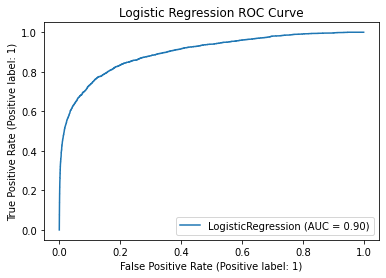

In [19]:
# display roc curve for the test set
RocCurveDisplay.from_estimator(logistic_model, X_test[:, select_columns], np.ravel(y_test))
plt.title("Logistic Regression ROC Curve")
plt.show()

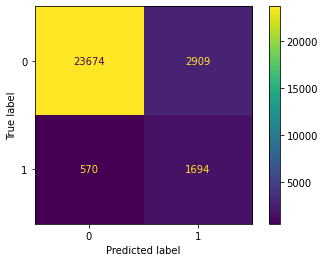

In [20]:
# display confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test[:, select_columns], np.ravel(y_test))
plt.show()

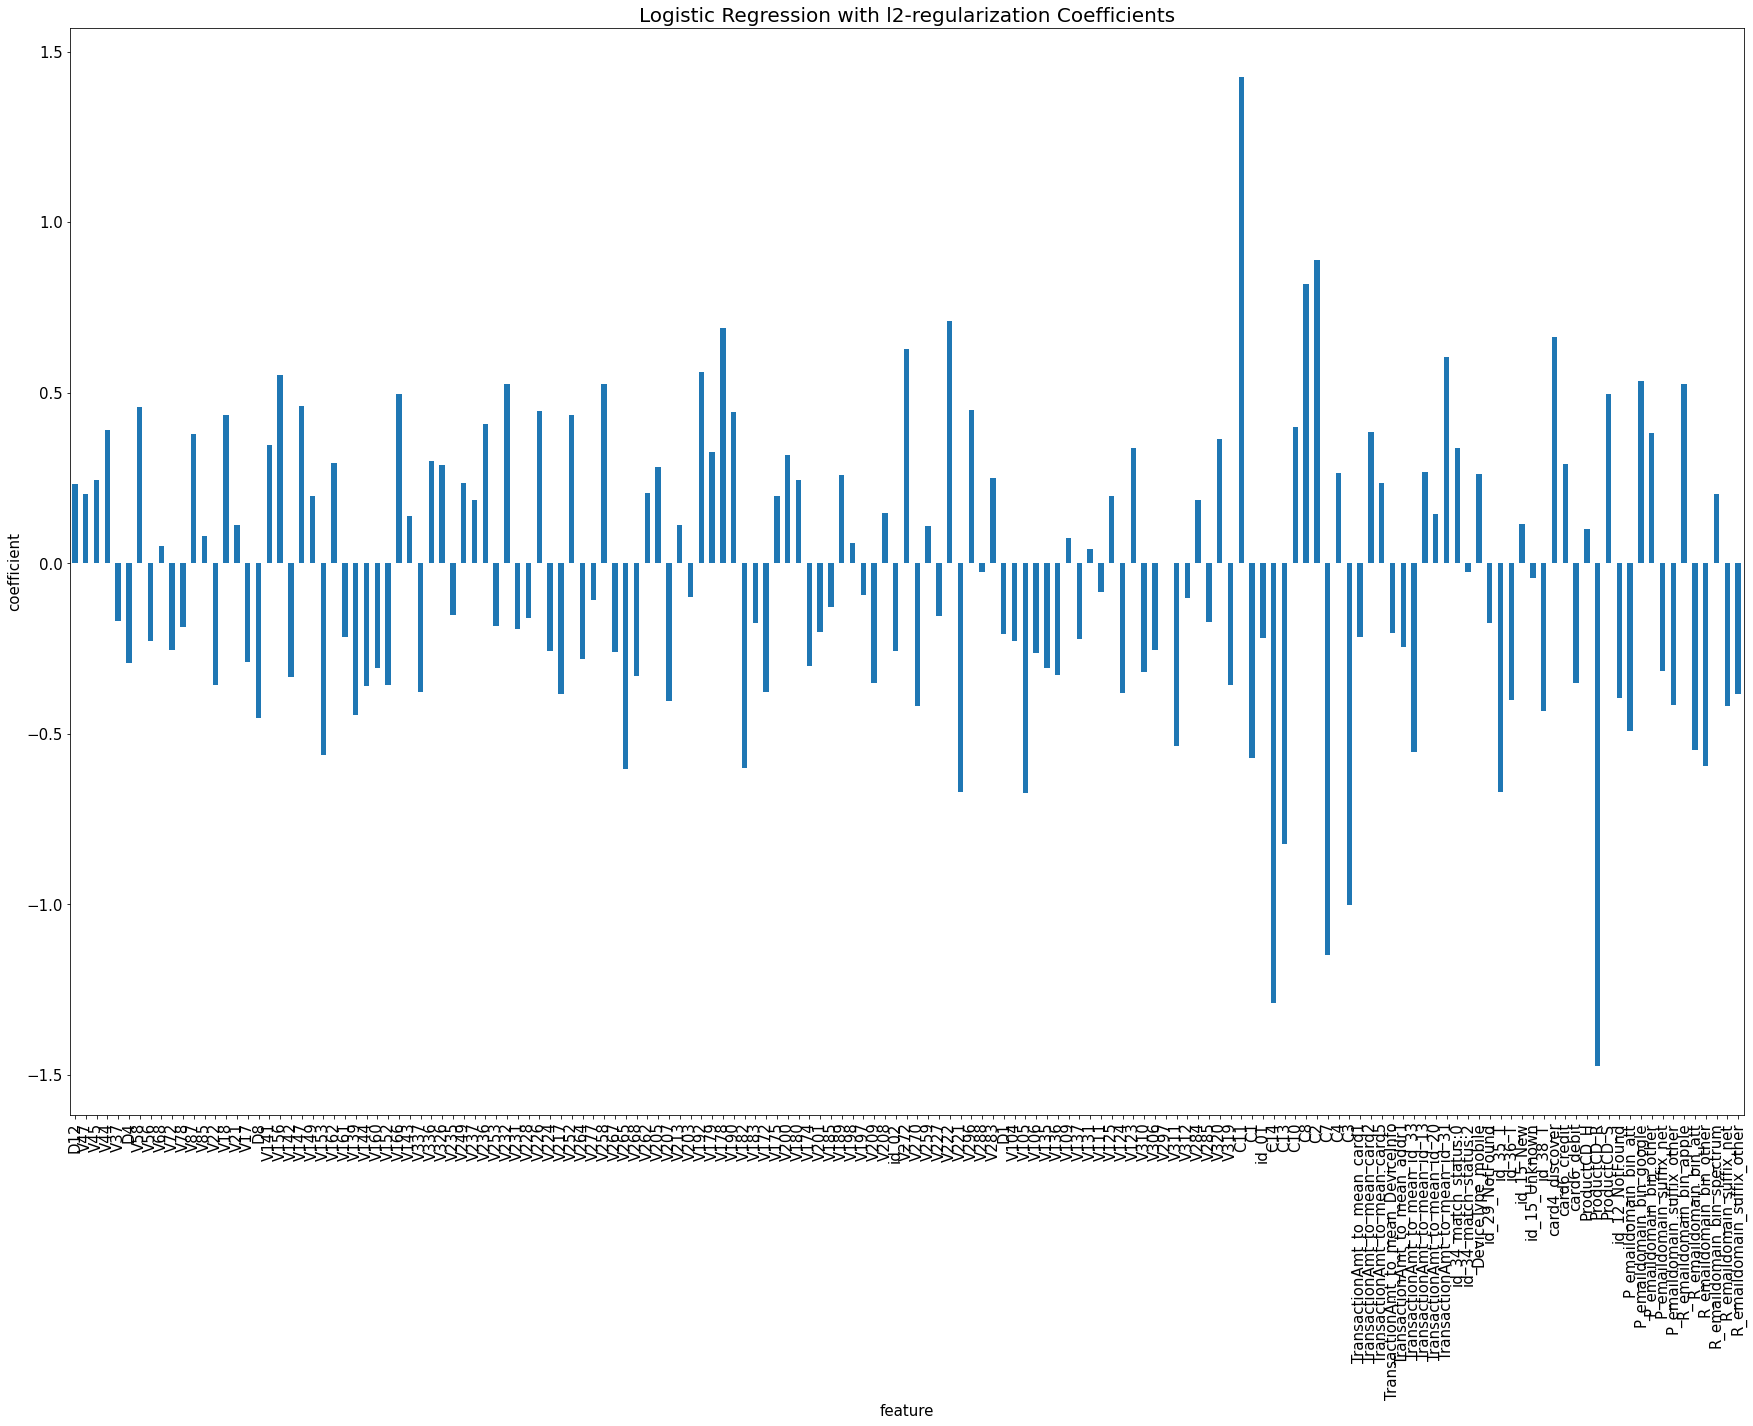

In [21]:
logistic_coefficients = pd.Series(logistic_model.coef_[0], index=feature_names[select_columns])
plt.figure(figsize=(30, 20))
logistic_coefficients.plot.bar()
plt.xlabel("feature", size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("coefficient", size=15)
plt.title("Logistic Regression with l2-regularization Coefficients", size=20)
plt.show()

In [13]:
logistic_coefficients

V47                           0.194596
V44                           0.386596
D4                            0.003262
V58                           0.317082
V61                          -0.083967
                                ...   
R_emaildomain_bin_apple       0.446646
R_emaildomain_bin_att        -0.679381
R_emaildomain_bin_other      -0.636374
R_emaildomain_suffix_net     -0.284203
R_emaildomain_suffix_other   -0.360867
Length: 147, dtype: float64

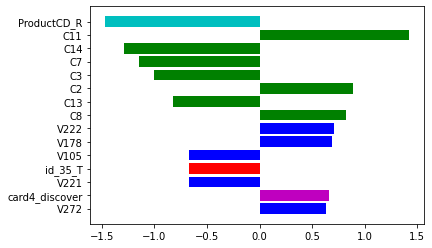

In [42]:
sort_coef = logistic_coefficients.sort_values(key=lambda x: -abs(x))

coef = list(sort_coef.index[0:15])
val = list(sort_coef.values[0:15])

val.reverse()
coef.reverse()

plt.barh(coef, val, color=['b','m','b','r','b','b','b','g','g','g','g','g','g','g','c'])
plt.show()

## Fit a Random Forest Classifier

In [ ]:
# Not run this
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train.shape[0], size=50000, replace=False)
parameters = {'n_estimators':[500, 1000], 'max_depth':[10,20,30], 'min_samples_split':[5, 10]}
rf = RandomForestClassifier(random_state=1)
best_rf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=5, n_jobs=7)
best_rf.fit(X_train[np.ix_(subsample, select_columns)], np.ravel(y_train.iloc[subsample]))

In [24]:
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train.shape[0], size=20000, replace=False)

rf = RandomForestClassifier(n_jobs = 5, max_depth = 20, min_samples_split = 5, n_estimators = 500, random_state=1)
rf.fit(X_train[np.ix_(subsample, select_columns)], np.ravel(y_train[subsample]))

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       n_jobs=5, random_state=1)

In [ ]:
#best_rf.best_estimator_ # best random forest model found

In [25]:
feature_import = pd.Series(rf.feature_importances_, index=feature_names[select_columns])
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

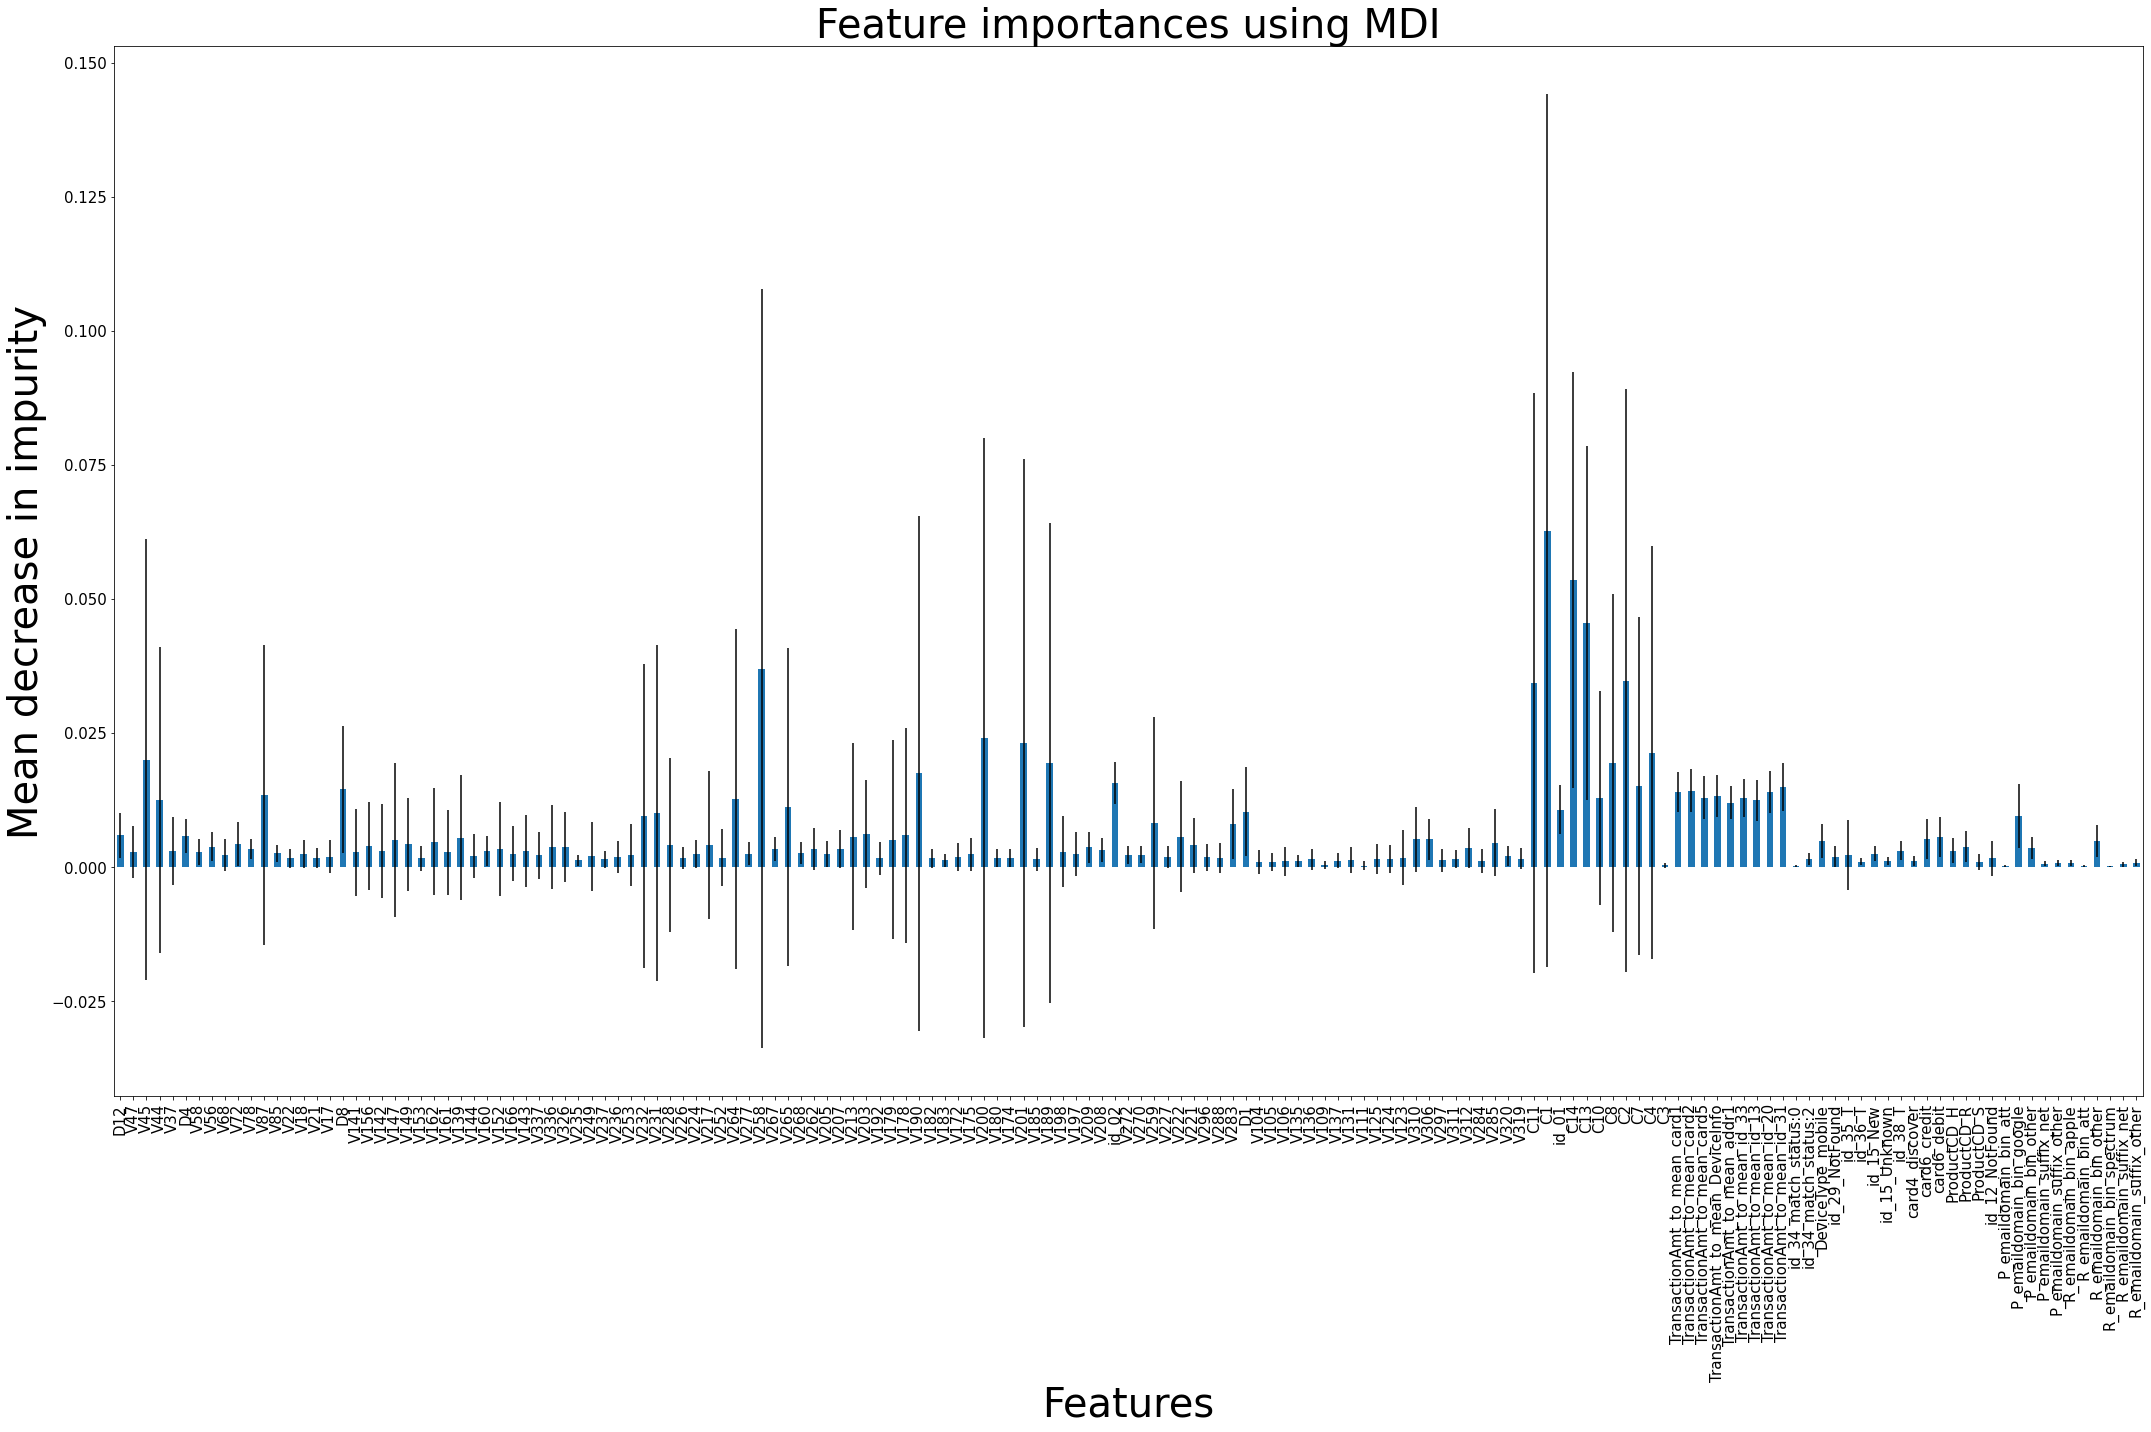

In [26]:
# error bars are standard deviation of the mean decrease impurity over all the decision trees
# in this case, there are 500 trees
fig, ax = plt.subplots(figsize=(30, 20))
feature_import.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI", size=40)
ax.set_ylabel("Mean decrease in impurity", size=40)
ax.set_xlabel("Features", size=40)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()

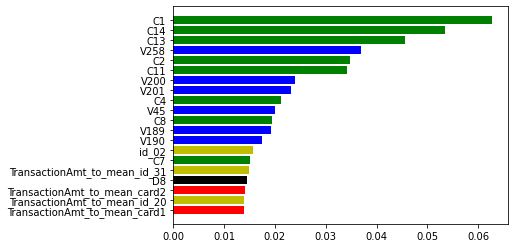

In [47]:
sort_coef = feature_import.sort_values(ascending = False)

coef = list(sort_coef.index[0:20])
val = list(sort_coef.values[0:20])

val.reverse()
coef.reverse()

plt.barh(coef, val, color=['r','y','r','k','y','g','y','b','b','g','b','g','b','b','g','g','b','g','g','g'])
plt.show()

In [18]:
import multiprocessing

multiprocessing.cpu_count()

24

In [17]:
# alternative feature importance (based on permutating the feature values)
rng = np.random.default_rng(2021)
subsample = rng.choice(X_test.shape[0], size=10000, replace=False)
result = permutation_importance(
    rf, X_test[np.ix_(subsample, select_columns)].toarray(), np.ravel(y_test.iloc[subsample]), n_repeats=5, 
    random_state=2021, n_jobs=24, scoring='roc_auc' 
)
forest_importances = pd.Series(result.importances_mean, index=feature_names[select_columns])
fig, ax = plt.subplots(figsize=(30, 20))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model", size=40)
ax.set_ylabel("Mean accuracy decrease", size=40)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

In [27]:
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), rf.predict_proba(X_test[:, select_columns])[:, 1])

0.9500200319314571

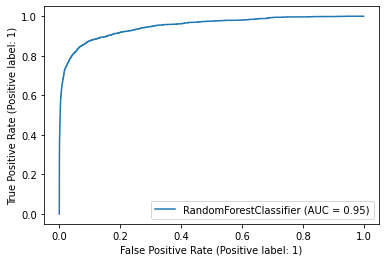

In [28]:
# display roc curve for the test set
RocCurveDisplay.from_estimator(rf, X_test[:, select_columns], np.ravel(y_test))

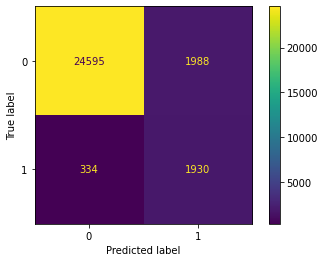

In [29]:
# display confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(rf, X_test[:, select_columns], np.ravel(y_test))
plt.show()

## Fit gradient boosting tree

In [24]:
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train.shape[0], size=100000, replace=False)
parameters = {'n_estimators':[200, 500], 'max_depth':[25, 30, 35], 'num_leaves':[25, 30, 35]}
gb = LGBMClassifier(random_state=2020, is_unbalance=True, objective='binary')
best_gb = GridSearchCV(gb, parameters, scoring='roc_auc', cv=5, n_jobs=24)
best_gb.fit(X_train[np.ix_(subsample, select_columns)], np.ravel(y_train.iloc[subsample]))
# lgb = LGBMClassifier(n_estimators=5000, is_unbalance=True, objective='binary', max_depth=50, n_jobs=3)
# lgb.fit(transactino_train_tr_2.iloc[1:50000, 2:], transactino_train_tr_2.iloc[1:50000, 1])

GridSearchCV(cv=5,
             estimator=LGBMClassifier(is_unbalance=True, objective='binary',
                                      random_state=2020),
             n_jobs=24,
             param_grid={'max_depth': [25, 30, 35], 'n_estimators': [200, 500],
                         'num_leaves': [25, 30, 35]},
             scoring='roc_auc')

In [25]:
best_gb.best_estimator_

LGBMClassifier(is_unbalance=True, max_depth=25, n_estimators=500, num_leaves=35,
               objective='binary', random_state=2020)

In [26]:
# roc score for the test set
prob = best_gb.best_estimator_.predict_proba(X_test[:, select_columns])[:,1]
roc_auc_score(np.ravel(y_test), prob)

0.96531725953607

In [27]:
# features importance based on number of splits
best_gb.best_estimator_.feature_importances_

array([  82,  132,  361,   29,   32,   41,   56,   21,  121,  139,   35,
         26,   30,   16,    9,    1,  805,   23,   96,   10,   57,   52,
         24,   70,  119,  100,  146,   83,  124,   91,   66,   18,   20,
         60,   19,   84,   32,   35,   48,   36,   74,   41,   16,   23,
         58,   22,   29,  139,   96,   11,  112,   97,   90,   47,   41,
         77,   64,   75,   67,   33,   20,   58,   23,   31,   25,   18,
          8,   10,   61,    8,   70,   33,    7,   79,   52,   55,   97,
       1079,  133,  135,   17,   70,   66,   48,  147,   51,   15,  371,
         17,   17,   28,   55,   32,   13,   16,   25,  146,  137,    7,
          7,   36,   14,   30,   83,  481,  225,  374,  285,  277,  104,
        266,  217,  277,   90,   41, 1018,  755,  762, 1079, 1092,   34,
         27,   45,   17,  128,   37,   24,   68,   83,   60,   98,   63,
        148,  106,   54,   17,    8,  156,  114,   93,   23,   29,   39,
         22,  125,   17,   11], dtype=int32)

In [28]:
# display roc curve for the test set
RocCurveDisplay.from_estimator(best_gb.best_estimator_, X_test[:, select_columns], np.ravel(y_test))

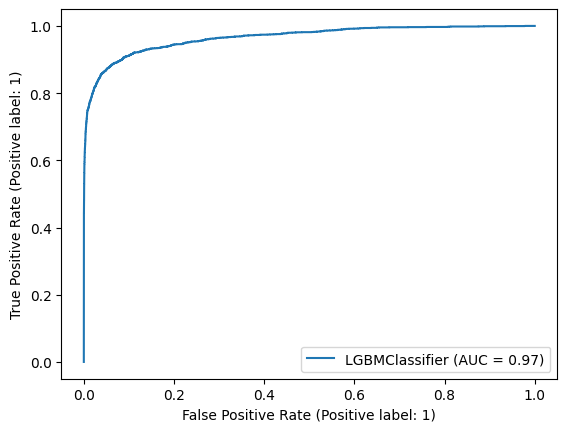

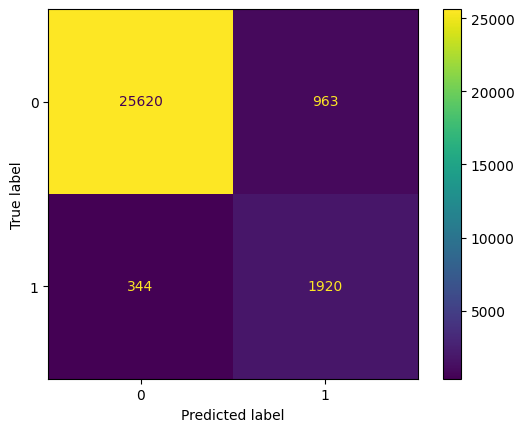

In [29]:
# display confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(best_gb.best_estimator_, X_test[:, select_columns], np.ravel(y_test))
plt.show()

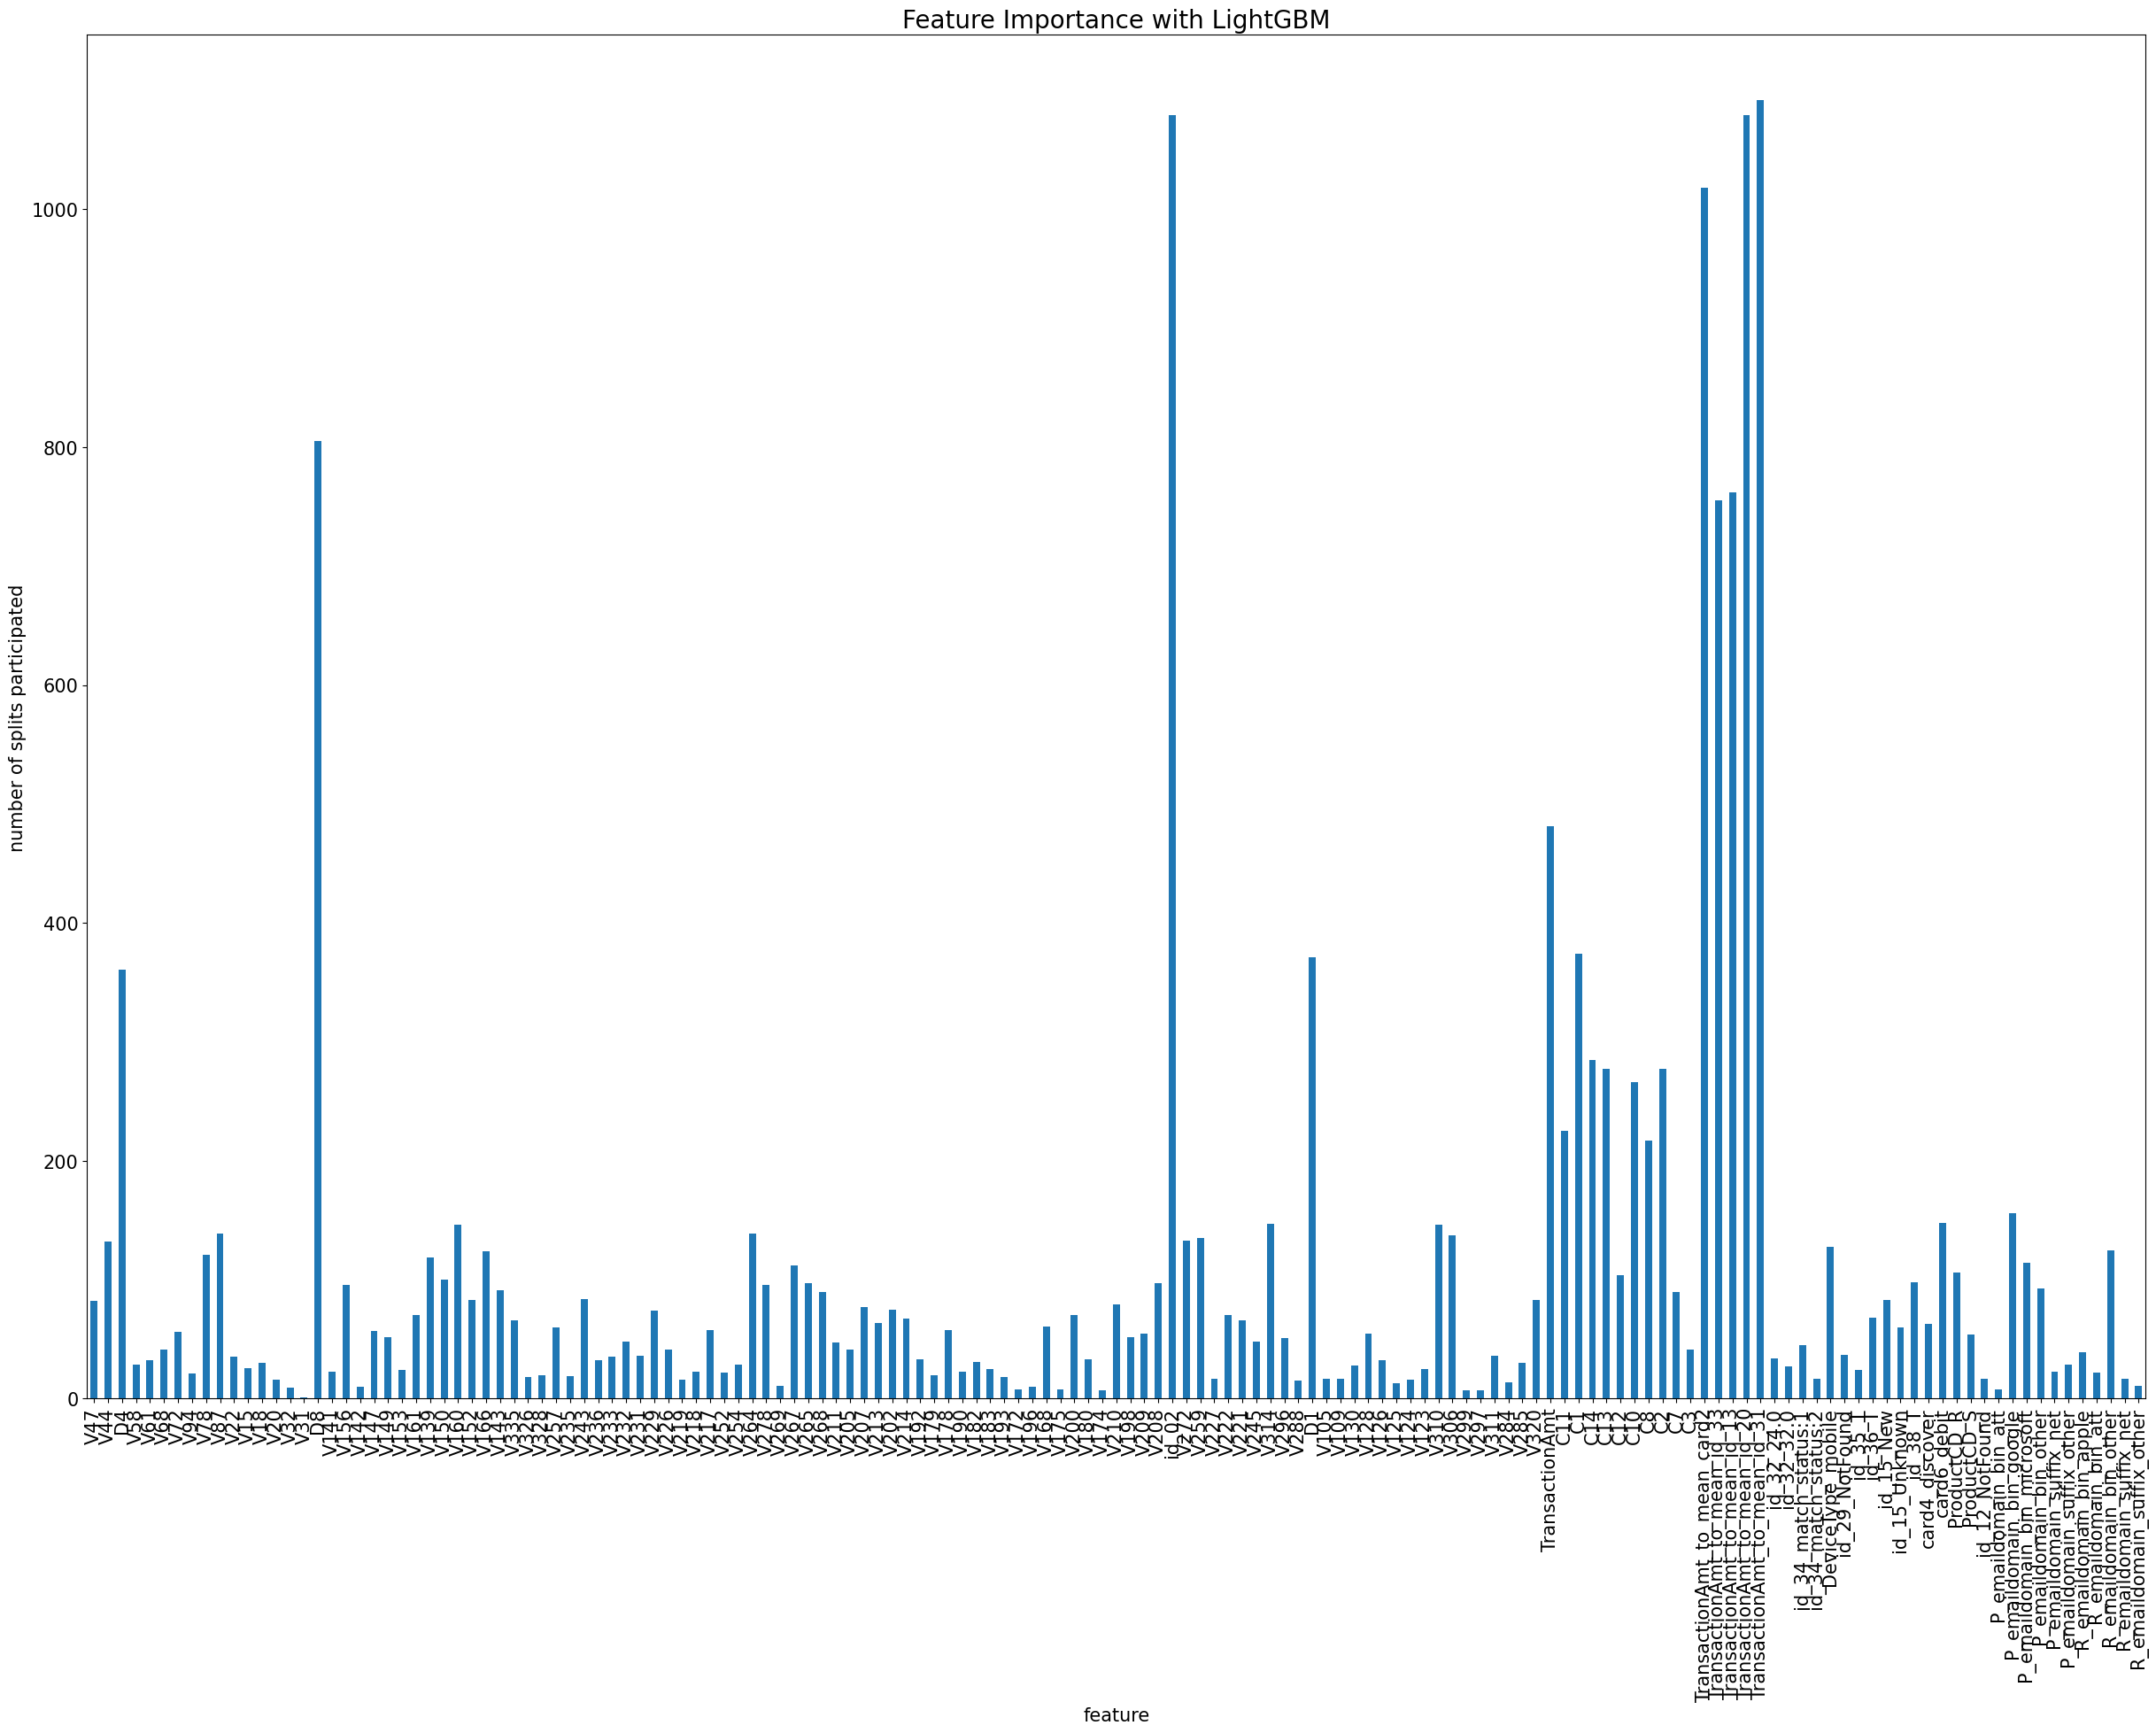

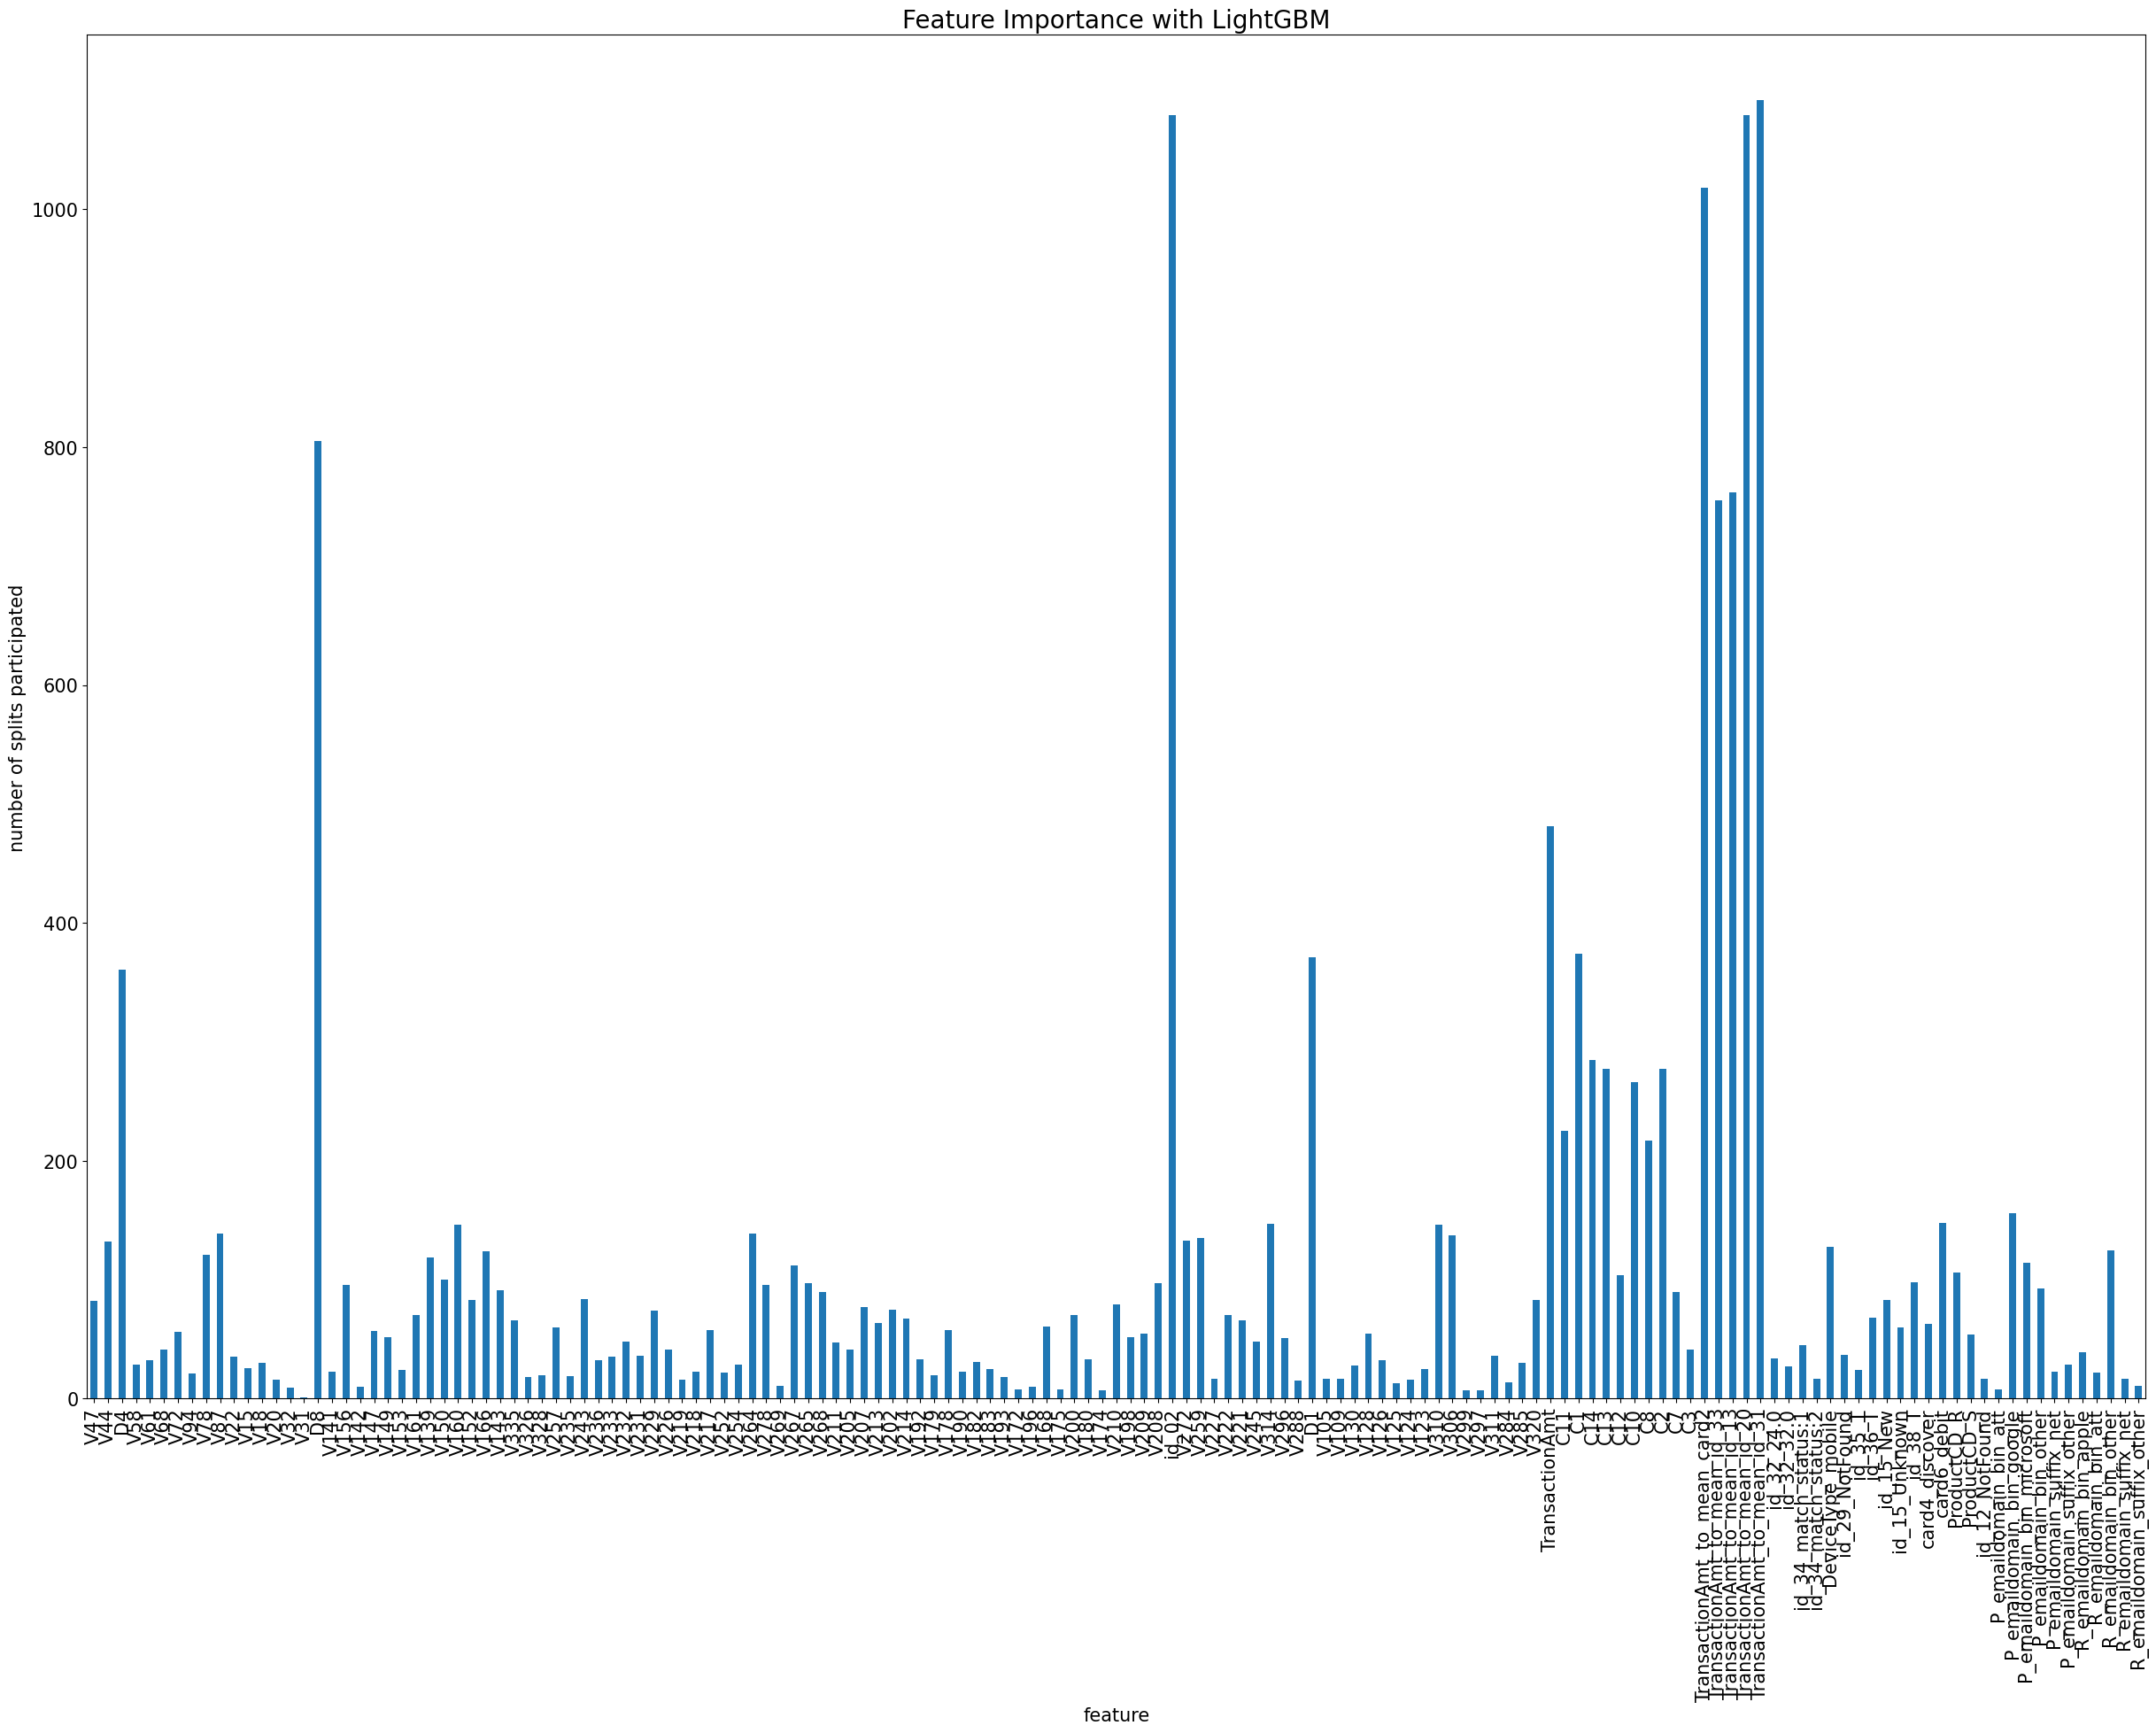

In [32]:
feature_import = pd.Series(best_gb.best_estimator_.feature_importances_, index=feature_names[select_columns])
plt.figure(figsize=(30, 20))
feature_import.plot.bar()
plt.xlabel("feature", size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("number of splits participated", size=15)
plt.title("Feature Importance with LightGBM", size=20)
plt.show()